# Introduction
* Lots of data collected every day
* Much of this is text data
* Impossible to parse through it manually to gain insights
* Automatic text processing used in doc. clustering, sentiment analysis, keyword extraction
* Here we use n-gram analysis, POS tagging and chunking, tf-idf, K-means, and LDA

# Data Collection
The data used for this project consist of news article descriptions from various sources around the world. To get these data, we can make use of the excellent [newsapi.org](https://newsapi.org) API, which happens to be very simple to use. On the newsapi homepage, one will see a "GET API KEY" in the upper right-hand corner. After clicking this link, you'll be asked to proved an email address and a password...and that's all there is to it! Well, almost. You'll be presented with something called an "API key", which is a long series of numbers and letters. This is sort of like a password, and is unique to each individual user. To try the API, simply type:

https://newsapi.org/v1/articles?source={NEWSSOURCE}&apiKey={APIKEY}

in the search bar. Before doing so, however, replace {APIKEY} with your own API key, and replace {NEWSSOURCE} with a news source like Bloomberg. So our link would then become something like:

https://newsapi.org/v1/articles?source=bloomberg&apiKey=633qw20c29984ce08504f5c89c2cmm02

Note that in the above example, that particular API key does not work, but is just used to demonstrate how this would be done in practice. The output looks something like this:

In [32]:
import requests

site = 'https://newsapi.org/v1/articles?source=bloomberg&apiKey=636cf20c29984ce08504f5c89c2cee02'
source_data = requests.get(site, allow_redirects=True).json()
print(json.dumps(source_data, indent=2)[:1890])

{
  "status": "ok",
  "source": "bloomberg",
  "sortBy": "top",
  "articles": [
    {
      "author": "Terrence Dopp, Chris Strohm",
      "title": "Trump Keeps Controversies Smoldering With a Warning for Comey",
      "description": "President Donald Trump fired off warnings and barely veiled threats in a burst of morning tweets that raised new questions about the dismissal of former FBI Director James Comey and kept attention on the investigation of Russian political meddling.",
      "url": "https://www.bloomberg.com/politics/articles/2017-05-12/comey-should-hope-there-are-no-tapes-trump-tweets",
      "urlToImage": "https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iaIMBW8gh14g/v0/1200x675.jpg",
      "publishedAt": "2017-05-12T13:13:33.48Z"
    },
    {
      "author": "Alexis Leondis, Lynnley Browning",
      "title": "Trump Lawyers: Tax Returns Show Little Income From Russians",
      "description": "President Donald Trump\u2019s personal lawyers said his tax returns from the pas

Each output is a set of nested dictionaries with information regarding the

* Article source (Bloomberg in this case)
* Sortby (top, latest, or popular)
* Author
* Article title
* Article description
* Article url
* Article image url
* Date of publish

### Automatically Collecting the Data
One of the great things about newsapi is that this sort of data can be collected from over 70 news sources and blogs from various parts of the world, some of which are not even in english. In order to fetch data like we've done above for many news sources, we need a way to automate the process. In general, the tasks we need to perform are:

* Loop over a bunch of new sources (e.g., Bloomberg, New York Times, etc.).
* For each news source, grab the top, latest, and popular articles.
* Get information from each article regarding title, description, url, etc.
* Save this data to a csv file for easy reading later on.

To this end, I wrote a Python module called scrapeNews.py to automatically perform the tasks listed above. I should note that Ahmed Besbes' [data science blog](http://ahmedbesbes.com) was an outstanding source of information for how to do this.

In [69]:
import pandas as pd
import requests
import os.path
import csv

API_key = '633qw20c29984ce08504f5c89c2cmm02'
outdir = '/Users/degravek/Downloads/'

def articleType():
    sort_by = ['top', 'latest', 'popular']
    source_id = ['associated-press', 'bbc-news', 'bbc-sport', 'bloomberg', 'business-insider',
                 'cnbc', 'cnn', 'daily-mail', 'engadget', 'entertainment-weekly', 'espn',
                 'financial-times', 'fortune', 'four-four-two', 'fox-sports', 'google-news',
                 'hacker-news', 'mtv-news', 'national-geographic', 'new-scientist', 'newsweek',
                 'nfl-news', 'reuters', 'talksport', 'techcrunch', 'techradar', 'the-economist',
                 'the-guardian-uk', 'the-huffington-post', 'the-new-york-times', 'the-next-web',
                 'the-sport-bible', 'the-telegraph', 'the-verge', 'the-wall-street-journal',
                 'the-washington-post', 'time', 'usa-today', 'ars-technica', 'al-jazeera-english']
    return source_id, sort_by

def getCategories():
    site = 'https://newsapi.org/v1/sources'
    source_info = requests.get(site).json()

    source_categories = {}
    for element in source_info['sources']:
        source_categories[element['id']] = element['category']
    return source_categories

def writeData(output):
    df = pd.DataFrame(output, columns=['publishedAt', 'author', 'category', 'title',
                                        'description', 'url'])
    df = df.drop_duplicates(subset='url')

    file_name = outdir + 'news_articles.csv'
    if os.path.isfile(file_name):
        df.to_csv(file_name, mode='a', encoding='utf-8', index=False, header=False)
    else:
        df.to_csv(file_name, mode='a', encoding='utf-8', index=False, header=True)

def scrapeNews():
    source_id, sort_by = articleType()
    source_categories = getCategories()

    output = []
    for sid in source_id:
        for sb in sort_by:
            # Get news article json
            site = 'https://newsapi.org/v1/articles?source=' + sid + '&sortBy=' + \
                    sb + '&apiKey=' + API_key

            source_data = requests.get(site).json()

            try:
                for element in source_data['articles']:
                    if not element['author']: element['author'] = 'no_author'
                    output.append([element['publishedAt'], element['author'],
                                    source_categories[sid], element['title'],
                                    element['description'], element['url']])
            except:
                pass

    writeData(output)

if __name__ == '__main__':
    scrapeNews()

The code above might look daunting at first, but it's actually not so bad. At the top, I define my API key and the directory where my file containing news articles will be saved. The function articleType() defines which news sources we're interested in grabbing articles from. From these sources, scrapeNews() will then grab the top, latest, and popular articles.

Every news source available is given a "category" by newsapi. For example, Bloomberg is given a "general" tag as this source generally covers many different news topics, while ESPN is given a "sport" tag. One will note that in our example earlier, though, category was not a key in the dictionary. The categories for each source can be instead be found here:

https://newsapi.org/v1/sources

The function getCategories() loops over every possible news source and grabs the corresponding category from the list. The result is a dictionary where the first ten entries look something like this:

In [67]:
site = 'https://newsapi.org/v1/sources'
source_info = requests.get(site).json()

source_categories = {}
for element in source_info['sources']:
    source_categories[element['id']] = element['category']

dict(zip(list(source_categories.keys())[:10], list(source_categories.values())[:10]))

{'abc-news-au': 'general',
 'al-jazeera-english': 'general',
 'ars-technica': 'technology',
 'associated-press': 'general',
 'bbc-news': 'general',
 'bbc-sport': 'sport',
 'bild': 'general',
 'bloomberg': 'business',
 'breitbart-news': 'politics',
 'business-insider': 'business'}

The function scrapeNews() then loops over each news source we've decided to use, finds its coresponding category using the dictionary above, and then grabs all the relevant news article information from that source using our API key.

Because we're collecting the top, latest, and popular articles for each source, there are bound to be duplicate articles included when we're done. Therefore, before writing the data to file, we drop duplicate entries based on the article url column. All of this is done in writeData().

### The Cron Job
We can run scrapeNews.py easily by calling **python scrapeNews.py** from the terminal command line. One will notice though that the number of news articles scraped after this run is only on the order of a few hundred or so $-$ not nearly enough for our purposes. We could manually run the code every 15 minutes or so, but that would be pretty tedious. To get around this, we can set up something called a "cron job" to execute the script for us automatically over fixed time intervals.

Setting up a cron job is pretty easy. In our case (working on a Mac), we need to follow three steps:

1. From the terminal command line, type **crontab -e**
2. In this prompt, enter the information regarding when the code will run (described below)
3. Type (if using nano) **control + o** to save the changes, then **control + x** to exit

For step (2), the input will look something like:

\* \* \* \* \* ~/anaconda/bin/python /Users/degravek/Site/news/scrapeNews.py

The second term in the line above (~/anaconda/bin/python) is the path to my python distribution, while the third term (/Users/degravek/Site/news/scrapeNews.py) is the absolute path to where scrapeNews.py is located. The five asterisks are palceholders that determine how frequently you want the code to be run, and their meaning is described well by the diagram below.

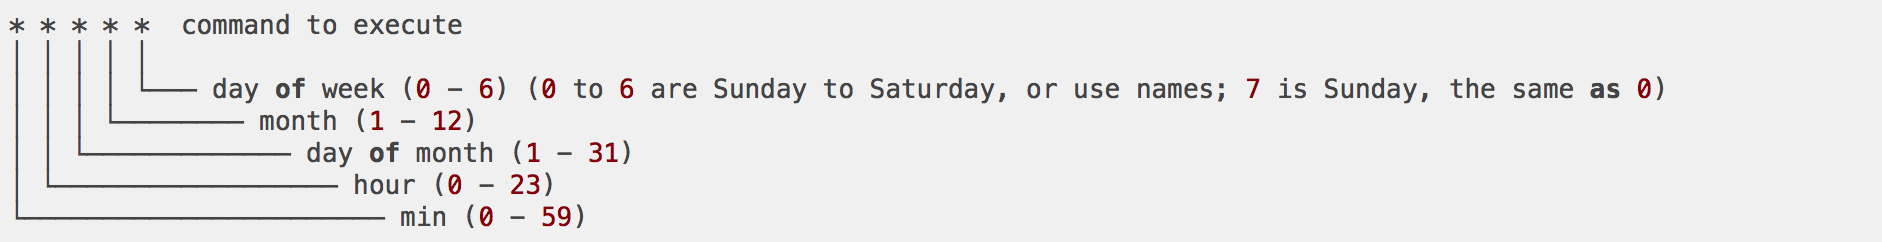

For this project, I ran scrapeNews.py every 15 minutes for a several days, so my input looked like

\*/15 \* \* \* \* ~/anaconda/bin/python /Users/degravek/Site/news/scrapeNews.py

When enough data has been collected, simply type **control -r** in the terminal command line to stop the cron job.

**NOTE:** To ensure that scrapeNews.py will run, **cd** to where the file is located and type **chmod +x scrapeNews.py** to make it executable.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from collections import Counter
from string import punctuation
import pandas as pd
import numpy as np
import nltk
import re

import matplotlib.pyplot as mp
%matplotlib inline

from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import plot, iplot
import cufflinks as cf
cf.go_offline()

stoplist = stopwords.words('english')

ModuleNotFoundError: No module named 'plotly'

Since the scrapeNews code was run every 15 minutes, and we've scraped the top, latest, and popular news articles, some news headlines are the same. Therefore, once the data are read in, we drop duplicates based on the "url" column, and drop any columns where the description was not available. This results in a dataset of size [].

Let's see what the data look like. We have
* Publish data
* Author
* Category
* Article itle
* Article Description
* Article url

We can check out the distribution of categories. I use plotly and cufflinks to do this, as they produce nice interactive figures with a function call similar to Pandas.

In [1043]:
df = pd.read_csv('/Users/degravek/Downloads/news_articles.csv')
df = df.drop_duplicates(subset='url')
df = df.reset_index(drop=True)

df = df[df['description'].notnull()].reset_index(drop=True)

df.loc[df['category'] == 'science-and-nature', 'category'] = 'science-nature'

In [1044]:
df.head()

,publishedAt,author,category,title,description,url
0,2017-05-10T23:08:03+00:00,BBC News,general,General election 2017: Labour manifesto draft ...,The document includes plans to nationalise par...,http://www.bbc.co.uk/news/uk-politics-39877439
1,2017-05-10T22:49:14+00:00,BBC News,general,Trump 'considered firing Comey since taking of...,Democratic senators say the FBI director was s...,http://www.bbc.co.uk/news/world-us-canada-3987...
2,2017-05-10T21:32:54+00:00,BBC News,general,Trump Russia meeting: Lavrov praises Trump and...,Russia's foreign minister said the talks were ...,http://www.bbc.co.uk/news/world-us-canada-3987...
3,2017-05-10T19:22:46+00:00,BBC News,general,Drayton Manor: Park to stay closed after Evha ...,Drayton Manor Theme Park will shut for a secon...,http://www.bbc.co.uk/news/uk-england-stoke-sta...
4,2017-05-10T18:39:07+00:00,BBC News,general,Women charged with terror offences and conspir...,A woman shot in a police raid is among three c...,http://www.bbc.co.uk/news/uk-39878398


In [1045]:
df['category'].value_counts().iplot(kind="bar", xTitle='Category', color='blue',
                            yTitle='Counts', dimensions=(790,550), margin=(100,100,60,0))

There are seven categories present:
* General
* Technology
* Business
* Sport
* Entertainment
* Science & Nature
* Music

General is sort of a catch-all category (often containing political news), and therefore has many more entries than the other categories. We see that the Science & Nature and Music categories are quite small here.

The goal of this work is to perform topic modeling on these news article descriptions using various techniques. Let's start by looking at common n-grams to see if we can gather what's being talked about in the news.

In [1046]:
for category in set(df['category']):
    print('Category:', category)
    print(df[df['category'] == category]['description'].tolist()[0])
    print('--------------------')

Category: science-nature
On his Texas ranch, John Wells set up a simple way to capture the secret lives of farm animals—and the occasional wild burro.
--------------------
Category: sport
Real Madrid hold off a spirited Atletico Madrid to set up a meeting with Juventus in next month's Champions League final in Cardiff.
--------------------
Category: general
The document includes plans to nationalise parts of the energy industry and scrap tuition fees.
--------------------
Category: music
Mini horse included
--------------------
Category: technology
Microsoft's Build developers' conference keynote today had few surprises and plenty of coding.
--------------------
Category: business
Senior Senate Republicans closed ranks behind President Donald Trump Wednesday after his dismissal of FBI Director James Comey, rejecting calls for a special prosecutor to investigate Russia’s meddling in the election and possible collusion with Trump’s campaign.
--------------------
Category: entertainment
T

# $n$-Gram Analysis
The method of $n$-gram analysis is one of the most common types of topic modeling techniques employed today. By $n$-gram analysis, I mean examining combinations of $n$ sequential words in a sentence. For example, the 1-grams (called unigrams) and 2-grams (called bigrams) of the sentence *"this is an example of a sentence"* would be:

* Unigrams: this, is, an, example, of, a, sentence
* Bigrams: this is, is an, an example, example of, of a, a sentence

In the first case, the unigrams are just a list of all single words in the sentence. In the second case, the bigrams are all sequential two-word combinations.

By looking at which $n$-grams occur most frequently in a document, we can get a sense for what is being talked about. In python, the $n$-grams can be computed in two ways $-$ manually using a function that we define ourselves, or automatically using Python Learn's CountVectorizer method. Let's try both!

Before the $n$-grams can be computed, we first have to process the text a little bit to remove puctuation and stop words. Stop words are words that occur so frequently in normal speech that they're of little interest to us. These include words like "the", "and", etc. We can define two functions below to perform these tasks $-$ they're called processText and rmStopwords. A third function called nGrams takes in some text, tokenizes it (i.e., splits it into its individual words) and finds the $n$ sequential word combinations. In this manual implementation, we can also perform an additional task that is helpful in identifying interesting words. If we're finding unigrams, the function tags the part of speech of each word and keeps only nouns, which are more likely to be the subject of a piece of text.

In [1047]:
punctuation = '!"#?$%“”&\'()’*+,./:;<=>@[\\]^_`{|}~…' #(removed - symbol)
def processText(text):
    result = text.lower()
    result = ''.join(word for word in result
                    if word not in punctuation)
    result = re.sub(r' +', " ", result).strip()
    return result

def rmStopwords(text):
    result = text.lower().split()
    result = ' '.join(word for word in result
                      if word not in stoplist)
    result = re.sub(r' +', " ", result).strip()
    return result

def nGrams(text, n):
    result = []
    text = text.split()
    if n==1:
        partspeech = nltk.pos_tag(text)
        result = [word for word, pos in
                  partspeech if pos[0] == 'N']
    else:
        for i in range(len(text)-(n-1)):
            result.append(' '.join(text[i:i+n]))
    if not result:
        result = np.nan
    return result

With these functions defined, we can now process the text and compute $n$-grams. In processing the text, we keep only those news articles where the description has more than 140 characters, as shorter descriptions sometimes don't contain a lot of useful information and generally add noise when performing topic modeling.

In [1048]:
df['pro_descr'] = df['description'].apply(rmStopwords).apply(processText)
df['num_chars'] = df['pro_descr'].apply(len)

df = df[df['num_chars'] > 140].reset_index(drop=True)

df['ngram_1']   = df['pro_descr'].apply(nGrams, args=(1,))
df['ngram_2']   = df['pro_descr'].apply(nGrams, args=(2,))
df['ngram_3']   = df['pro_descr'].apply(nGrams, args=(3,))

Let's see the unigrams, bigrams, and trigrams.

In [1049]:
df[['description','ngram_1','ngram_2','ngram_3']].head()

,description,ngram_1,ngram_2,ngram_3
0,Senior Senate Republicans closed ranks behind ...,"[senate, republicans, ranks, president, donald...","[senior senate, senate republicans, republican...","[senior senate republicans, senate republicans..."
1,"At the moment, the criminal probe into Russia’...","[moment, probe, russias, meddling, election, s...","[moment criminal, criminal probe, probe russia...","[moment criminal probe, criminal probe russias..."
2,Aetna Inc. will leave the few remaining states...,"[aetna, inc, states, plans, year, health, insu...","[aetna inc, inc leave, leave remaining, remain...","[aetna inc leave, inc leave remaining, leave r..."
3,"The city of Portland, Oregon, is starting its ...","[city, portland, oregon, investigation, uber, ...","[city portland, portland oregon, oregon starti...","[city portland oregon, portland oregon startin..."
4,United Continental Holdings Inc. directors wer...,"[continental, holdings, directors, pension, fu...","[united continental, continental holdings, hol...","[united continental holdings, continental hold..."


We can now see which $n$-grams occur most frequently in each category.

In [1050]:
def keywords_ngram(category, n, num):
    text = df[df['category'] == category]['ngram_' + str(n)]
    result = []
    for word_list in text:
        result += word_list
    return Counter(result).most_common(num)

for category in set(df['category']):
    print("Category:", category)
    print("1-grams:", keywords_ngram(category, 1, 10))
    print('--------------------')
    print("2-grams:", keywords_ngram(category, 2, 10))
    print('--------------------')
    print("3-grams:", keywords_ngram(category, 3, 10))
    print('--------------------')

Category: business
1-grams: [('president', 16), ('director', 15), ('james', 12), ('trump', 10), ('donald', 10), ('investigation', 7), ('fbi', 7), ('house', 6), ('officials', 5), ('plans', 4)]
--------------------
2-grams: [('director james', 11), ('james comey', 11), ('fbi director', 11), ('president donald', 10), ('donald trump', 8), ('white house', 6), ('attorney general', 4), ('bureau investigation', 4), ('chief executive', 4), ('federal bureau', 4)]
--------------------
3-grams: [('director james comey', 10), ('fbi director james', 8), ('president donald trump', 7), ('federal bureau investigation', 4), ('chief executive officer', 3), ('insurance giant aig', 2), ('general rod rosenstein', 2), ('fire fbi director', 2), ('giant aig plans', 2), ('house official said', 2)]
--------------------
Category: sport
1-grams: [('season', 34), ('league', 28), ('game', 17), ('club', 15), ('ap', 15), ('manchester', 14), ('summer', 14), ('night', 14), ('manager', 13), ('champions', 13)]
-----------

Now let's perform the same exercise, but using Scikit-Learn's CountVectorizer instead.

In [1051]:
def keywords_cvec(category, n, num):
    text = df[df['category'] == category]['pro_descr']

    vector = CountVectorizer(min_df=1, strip_accents='unicode', analyzer='word',
                     token_pattern=r'\w{1,}', ngram_range=(n,n), stop_words=stoplist)
    cvec = vector.fit_transform(text)

    feature_names = vector.get_feature_names()
    feature_count = cvec.toarray().sum(axis=0)
    sort_feature = sorted(zip(feature_names, feature_count), key=lambda x: x[1], reverse=True)[:num]
    return sort_feature

In [1052]:
for category in set(df['category']):
    print("Category:", category)
    print("1-grams:", keywords_cvec(category, 1, 10))
    print('--------------------')
    print("2-grams:", keywords_cvec(category, 2, 10))
    print('--------------------')
    print("3-grams:", keywords_cvec(category, 3, 10))
    print('--------------------')

Category: business
1-grams: [('president', 16), ('trump', 16), ('director', 15), ('fbi', 13), ('comey', 12), ('donald', 12), ('james', 12), ('said', 9), ('us', 8), ('first', 7)]
--------------------
2-grams: [('director james', 11), ('fbi director', 11), ('james comey', 11), ('president donald', 10), ('donald trump', 9), ('white house', 6), ('attorney general', 4), ('bureau investigation', 4), ('chief executive', 4), ('federal bureau', 4)]
--------------------
3-grams: [('director james comey', 10), ('fbi director james', 8), ('president donald trump', 8), ('federal bureau investigation', 4), ('chief executive officer', 3), ('aig plans name', 2), ('attorney general rod', 2), ('bureau investigation director', 2), ('deputy attorney general', 2), ('donald trump said', 2)]
--------------------
Category: sport
1-grams: [('league', 42), ('season', 37), ('ap', 33), ('final', 23), ('premier', 23), ('first', 22), ('united', 22), ('year', 22), ('former', 21), ('game', 21)]
--------------------
2

We see that in the business category, for example, many news articles tend to focus a great deal on Donald Trump, former FBI director James Comey, and former director of the Defense Intelligence Agency Michael Flynn. Let's plot the ten most frequent trigrams.

In [1053]:
ngram = pd.DataFrame(keywords_ngram('general', 3, 10), columns=['ngram_3','counts'])

plot = ngram.iplot(kind="bar", x='ngram_3', y='counts', xTitle='Trigrams', color='blue',
                            yTitle='Counts', dimensions=(790,550), margin=(80,120,110,20))

Another common method used in topic modeling is called noun-phrase chunking. The idea is to find nouns and surrounding descriptive words in the text, as these phrases often carry the main point (i.e., the topic) of a sentence. I was first introduced to the idea of chunking from [this super informative article](http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/) about topic modeling.

To perform chunking, the first thing we have to do is define a "chunking pattern" (this is the string of symbols in the function argument). The chunking pattern tells the function which sort of phrases to look for in the text. In our case, it's one or more optional adjectives followed by one or more nouns. Let's try it out!

In [1054]:
def extract_candidate_chunks(text, grammar = 'CHUNK: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string
    parser = nltk.RegexpParser(grammar)
    tagged_sents = [nltk.pos_tag(nltk.word_tokenize(text))]

    for chunk in tagged_sents:
        if not chunk:
            candidates = []
        else:
            candidates = []
            tree = parser.parse(chunk)
            for subtree in tree.subtrees():
                if subtree.label() == 'CHUNK':
                    candidates.append((' '.join([word for (word, tag) in subtree.leaves()])))
    candidates = [word for word in candidates if word not in stoplist]
    return candidates

In [1055]:
def keyphrases_chunk(category, num):
    tokens = df[df['category'] == category]['chunk']
    
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(num)

In [1056]:
df['chunk'] = df['pro_descr'].apply(extract_candidate_chunks)

In [1057]:
for category in set(df['category']):
    print("Category:", category)
    print("chunk:", keyphrases_chunk(category, 15))
    print('--------------------')

Category: business
chunk: [('fbi director james', 4), ('president donald', 4), ('trump', 2), ('investigation', 2), ('president donald trump', 2), ('election', 2), ('mccabe', 2), ('general rod rosenstein', 2), ('markets', 2), ('former federal bureau investigation director james', 2), ('justice department', 2), ('white house official', 2), ('deputy attorney', 2), ('attorney', 2), ('apparent bid', 1)]
--------------------
Category: sport
chunk: [('goals', 8), ('games', 7), ('talksport', 6), ('summer', 6), ('host manchester', 5), ('homage heroes past present', 5), ('tottenham hotspur bid', 5), ('final game', 5), ('white hart lane', 5), ('grand old stadium', 5), ('last time', 5), ('field', 5), ('champions', 5), ('points', 5), ('innings', 4)]
--------------------
Category: general
chunk: [('thursday', 19), ('fbi director james', 18), ('united states', 10), ('trump', 8), ('people', 8), ('president', 8), ('wednesday', 8), ('years', 7), ('president donald', 7), ('election', 7), ('senate intelli

We see that chunking also does a pretty good job in grabbing the main topics of the text. The results are similar to the mixture of unigrams, bigrams, and trigrams found using $n$-gram analysis, but they also contain longer, more informative strings like "crash hillside near medellin international airport colombia" and "former federal bureau investigation director james".

# Term-Frequency Inverse Document Frequency
What is tf-idf?

See if we can cluster tweets by their content using TF-IDF

In [1058]:
tfidf = TfidfVectorizer(min_df=10, max_features=10000, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

tfidf_descr = tfidf.fit_transform(df['pro_descr'])

In [1059]:
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf_df = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(), columns=['tfidf_val'])
tfidf_df.sort_values('tfidf_val', ascending=False, inplace=True)

In [1060]:
tfidf_df.head()

,tfidf_val
users,4.951244
international,4.951244
away,4.951244
early,4.951244
behind,4.951244


In [1061]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(tfidf_descr)

In [1062]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, learning_rate=10)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 0.321581
[t-SNE] KL divergence after 50 iterations with early exaggeration: 2.496156
[t-SNE] Error after 300 iterations: 2.496156


In [1063]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = df['description']
tfidf_df['category'] = df['category']

In [1160]:
tfidf_df.iplot(kind="scatter", x='x', y='y', mode='markers', size=5, text='description',
              dimensions=(790,650), margin=(50,50,40,40), color='blue')

# K-Means Clustering

In [1167]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 8

kmeans_model = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=100,
                               batch_size=100, verbose=False, max_iter=1000, random_state=3)

kmeans = kmeans_model.fit(tfidf_descr)
kmeans_clusters = kmeans.predict(tfidf_descr)
kmeans_distances = kmeans.transform(tfidf_descr)

In [1168]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()

for i in range(15):
    print("Cluster %d:" % i)
    for ind in sorted_centroids[i, :10]:
        print(terms[ind], end=' / ')
    print('\n', '--------------------')

Cluster 0:
new / one / may / two / week / party / us / election / state / last / 
 --------------------
Cluster 1:
fbi / president / trump / donald / director / president donald / comey / fbi director / james / james comey / 
 --------------------
Cluster 2:
thursday / said / said thursday / us / minister / likely / chief / european / states / head / 
 --------------------
Cluster 3:
first / year / old / year old / half / three / day / last / and / five / 
 --------------------
Cluster 4:
ap / intelligence / committee / senate / intelligence committee / senate intelligence / senate intelligence committee / beat / wednesday / washington / 
 --------------------
Cluster 5:
league / manchester / final / united / season / manchester united / premier / premier league / champions / old / 
 --------------------
Cluster 6:
wednesday / said wednesday / said / inc / us / reported / many / company / snap / secretary / 
 --------------------
Cluster 7:
today / microsoft / software / windows / buil

IndexError: index 8 is out of bounds for axis 0 with size 8

In [1169]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, learning_rate=500)
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

df_kmeans = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
df_kmeans['cluster'] = kmeans_clusters
df_kmeans['description'] = df['description']
df_kmeans['category'] = df['category']

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 0.030713
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.615566
[t-SNE] Error after 425 iterations: 0.615566


In [1170]:
colormap = ["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9",
            "#68af4e", "#6e6cd5", "#e3be38", "#4e2d7c", "#5fdfa8"]

color_dict = dict(zip(range(0,10), colormap))

df_kmeans['color'] = df_kmeans['cluster'].map(color_dict)

In [1180]:
#df_kmeans.iplot(kind="scatter", x='x', y='y', mode='markers', size=5, text='description',
#dimensions=(750,650), margin=(0,0,0,0))

import plotly.graph_objs as go

trace = go.Scatter(
    y = df_kmeans['y'],
    x = df_kmeans['x'],
    mode = 'markers',
    text = df['description'],
    marker = dict(size='5', color=df_kmeans['color'].tolist())
    )

df_kmeans.iplot([trace], dimensions=(790,650), margin=(50,50,40,40))

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>